# 🧠 Manual Decision Tree from Scratch
This notebook demonstrates the intuition and step-by-step implementation of Decision Trees for classification problem.
We will use a simple dataset (`Insurance_Claim_Dataset.csv`) to correctly predict the classification whether some features can be classified as potentially claim or not.

This notebook demonstrates how **decision trees** fits a classification problem  
using **gini impurity** from scratch — without `sklearn`.

We will:
- Use all feature
- Define the **Gini Impurity** and calculate the **Weighted Gini** for each features
- Derive and apply decision trees step-by-step
- Find the root and leaves of the trees along with feature reductions
- Plot results
- Find the accuracy of the model

## 📦 1. Load and Prepare Data

In [1]:
import pandas as pd
from collections import Counter

# Load the dataset
df = pd.read_csv("data/insurance_claim_dataset.csv")

# Select features and target
features = ['Age', 'Sex', 'Smoker', 'BMI', 'Sport']
target = 'Claim'
X = df[features].values
y = df[target].values

df.head()

,Age,Sex,Smoker,BMI,Sport,Claim
0,56,0,0,31.6,1,0
1,46,1,0,25.1,1,0
2,32,0,0,24.3,0,0
3,60,1,1,32.4,1,0
4,25,1,0,18.9,0,0


In [2]:
# Combine into a single list
data = [list(row) + [label] for row, label in zip(X, y)]
data[0]

[np.float64(56.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(31.6),
 np.float64(1.0),
 np.int64(0)]

## 📊 2. Gini Impurity Calculation

$$
\text{Gini}(t) = 1 - \sum_{i=1}^{C} p_i^2
$$

Where:
- \( C \): number of classes  
- \( p_i \): proportion of class \( i \) in the node


In [3]:
def gini_impurity(rows):
    counts = Counter([row[-1] for row in rows])
    impurity = 1
    total = len(rows)
    for lbl in counts:
        prob_of_lbl = counts[lbl] / total
        impurity -= prob_of_lbl ** 2
    return impurity

gini_impurity(data)

0.48

## ✂️ 3. Split Data and Weighted Gini

we're gonna testing whether 50 is the best split?

In [4]:
def split_data(rows, feature_index, threshold):
    left = [row for row in rows if row[feature_index] <= threshold]
    right = [row for row in rows if row[feature_index] > threshold]
    return left, right

def weighted_gini(left, right):
    total = len(left) + len(right)
    return (len(left) / total) * gini_impurity(left) + (len(right) / total) * gini_impurity(right)

left, right = split_data(data, 0, 50)
weighted_gini(left, right)

0.4420345267060596

## 📊 4. Best Split for One Feature (e.g., Age)

### Gini Impurity Calculation for Threshold Age ≤ 47

We evaluate the quality of a potential split using the **Gini impurity**. Here's how we calculate it step-by-step for threshold **Age ≤ 47**:

---

#### ✅ Left Group (`Age ≤ 47`)
- Number of samples: **126**
- Class distribution:  
  - Claim = 0 → 92  
  - Claim = 1 → 34

$$
\text{Gini}_{\text{left}} = 1 - \left(\frac{92}{126}\right)^2 - \left(\frac{34}{126}\right)^2 = 1 - 0.7302^2 - 0.2698^2 ≈ 0.3941
$$

---

#### ✅ Right Group (`Age > 47`)
- Number of samples: **74**
- Class distribution:  
  - Claim = 1 → 46  
  - Claim = 0 → 28

$$
\text{Gini}_{\text{right}} = 1 - \left(\frac{46}{74}\right)^2 - \left(\frac{28}{74}\right)^2 = 1 - 0.6216^2 - 0.3784^2 ≈ 0.4704
$$

---

#### ⚖️ Weighted Gini Impurity

$$
\text{Gini}_{\text{weighted}} = \frac{126}{200} \cdot 0.3941 + \frac{74}{200} \cdot 0.4704 ≈ 0.4223
$$

---

✅ Therefore, **Age ≤ 47** gives a total weighted Gini impurity of **0.4223**, making it a strong candidate for a split point in the decision tree.


In [5]:
def find_best_split_for_feature(rows, feature_index):
    best_gini = 1
    best_threshold = None
    unique_values = sorted(set([row[feature_index] for row in rows]))
    for threshold in unique_values:
        left, right = split_data(rows, feature_index, threshold)
        if len(left) == 0 or len(right) == 0:
            continue
        gini = weighted_gini(left, right)
        if gini < best_gini:
            best_gini = gini
            best_threshold = threshold
    return best_threshold, best_gini

find_best_split_for_feature(data, 0)

(np.float64(47.0), 0.42230802230802233)

## 🔍 5. Best Split Across All Features

### 🌳 Finding the Best Feature for the Root Node

To determine the best feature to split at the **root node**, we loop through **all features** and calculate the best possible threshold and corresponding Gini impurity for each.

We use the function:

In [6]:
def find_best_split(rows):
    best_feature = None
    best_threshold = None
    best_gini = 1
    num_features = len(rows[0]) - 1
    for feature_index in range(num_features):
        threshold, gini = find_best_split_for_feature(rows, feature_index)
        if gini < best_gini:
            best_gini = gini
            best_threshold = threshold
            best_feature = feature_index
    return best_feature, best_threshold, best_gini

find_best_split(data)

(0, np.float64(47.0), 0.42230802230802233)

## 🌳 6a. Recursive Tree Building

Once we've identified the best feature and threshold for splitting at the current node, we can recursively apply the same logic to the resulting **left** and **right** subsets.

This recursive process continues until one of the following stopping conditions is met:
- All rows belong to the same class (pure node)
- No further information gain can be achieved
- Optionally, we can add max depth or min samples as stopping criteria

In this case we try to set max_depth = 3 based on
### 📌 Choosing the Right `max_depth` Value

The `max_depth` parameter controls how deep the decision tree can grow. It helps prevent overfitting by limiting how specific the tree becomes when fitting to the training data.

Here are some general recommendations for selecting `max_depth`:

| Scenario                          | Recommended `max_depth` |
|----------------------------------|--------------------------|
| You want a simple, interpretable model | **2–4**                  |
| Your dataset is large or complex        | **5–10**                 |
| You're tuning hyperparameters          | Use **GridSearchCV** to find the optimal value |

💡 The ideal `max_depth` depends on your specific dataset and goals. Always validate performance using cross-validation to avoid overfitting or underfitting.

Later we'll try to compare this results with model with scikit learn library and GridSearchCV cross validation from another notebook

In [7]:
class DecisionNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

def class_counts(rows):
    return Counter([row[-1] for row in rows])

def build_tree(rows, depth=0, max_depth=3):
    labels = [row[-1] for row in rows]
    if len(set(labels)) == 1:
        return DecisionNode(value=labels[0])
    if depth >= max_depth:
        majority_label = class_counts(rows).most_common(1)[0][0]
        return DecisionNode(value=majority_label)
    feature, threshold, gini = find_best_split(rows)
    if feature is None:
        majority_label = class_counts(rows).most_common(1)[0][0]
        return DecisionNode(value=majority_label)
    left_rows, right_rows = split_data(rows, feature, threshold)
    left_branch = build_tree(left_rows, depth + 1, max_depth)
    right_branch = build_tree(right_rows, depth + 1, max_depth)
    return DecisionNode(feature, threshold, left_branch, right_branch)

tree = build_tree(data)

## 🌳 6b. Feature Usage Frequency

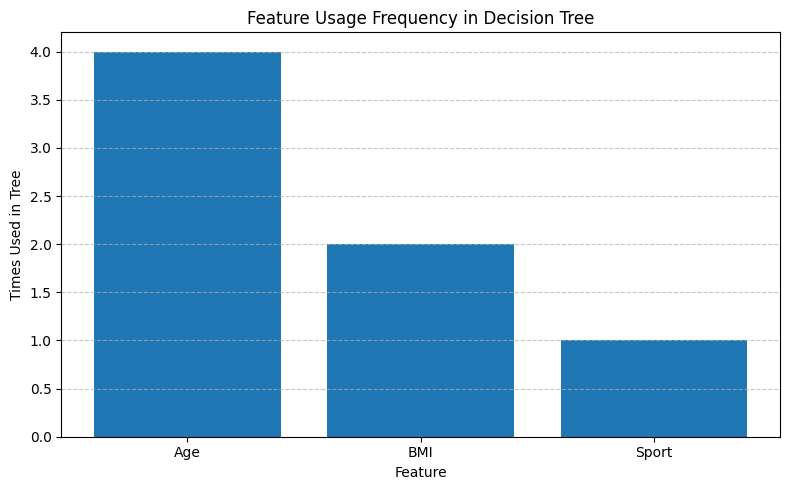

In [8]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Fungsi untuk menghitung seberapa sering setiap fitur dipakai
def count_feature_usage(node, counter=None):
    if counter is None:
        counter = defaultdict(int)
    if node is None or node.value is not None:
        return counter
    counter[node.feature] += 1
    count_feature_usage(node.left, counter)
    count_feature_usage(node.right, counter)
    return counter

# Hitung frekuensi pemakaian fitur
feature_usage = count_feature_usage(tree)
feature_usage_named = {features[i]: count for i, count in feature_usage.items()}

# Buat bar chart
plt.figure(figsize=(8, 5))
plt.bar(feature_usage_named.keys(), feature_usage_named.values())
plt.title("Feature Usage Frequency in Decision Tree")
plt.xlabel("Feature")
plt.ylabel("Times Used in Tree")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### 🧹 Automatic Feature Reduction in Decision Trees

One of the powerful properties of decision trees is that they perform **feature selection automatically** as part of the tree-building process.

---

#### ✅ How It Works:

At each node, the tree:
1. Evaluates all available features and thresholds
2. Selects the **feature and threshold that produce the greatest reduction in impurity** (e.g., Gini)
3. Builds subtrees only from the **best split**, and completely ignores the rest

This means:
- Features that do **not help reduce impurity** are **never used**
- They are effectively **eliminated** from the model — even though they were originally part of the dataset

---

#### 🧠 Real Example from Our Notebook:

Out of 5 features:
- **Used in tree**: `Age`, `BMI`, `Sport`
- **Not used at all**: `Sex`, `Smoker`

These unused features were **automatically excluded** because they never provided a better split than the selected ones.

---

#### 🎯 Key Takeaway:
> Decision trees naturally perform **feature reduction** by **only using the most informative features** at each step, making them not only predictive but also interpretable and efficient.


## 🎯 7. Prediction Function

After the decision tree is built, we use a recursive function to **predict the label** of a new data point by traversing the tree from root to leaf.

---

#### 🧠 Function: `predict(row, node)`

In [9]:
def predict(row, node):
    if node.value is not None:
        return node.value
    if row[node.feature] <= node.threshold:
        return predict(row, node.left)
    else:
        return predict(row, node.right)

[predict(row, tree) for row in data[:5]]

[np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]

## 📜 8a. Print Tree (Text-based)

In [10]:
feature_names = ['Age', 'Sex', 'Smoker', 'BMI', 'Sport']

def print_tree(node, spacing=""):
    if node.value is not None:
        print(spacing + f"Predict → {node.value}")
        return
    print(spacing + f"If {feature_names[node.feature]} ≤ {node.threshold}:")
    print(spacing + "--> True:")
    print_tree(node.left, spacing + "   ")
    print(spacing + "--> False:")
    print_tree(node.right, spacing + "   ")

print_tree(tree)

If Age ≤ 47.0:
--> True:
   If BMI ≤ 29.6:
   --> True:
      If Age ≤ 28.0:
      --> True:
         Predict → 0
      --> False:
         Predict → 0
   --> False:
      If Age ≤ 44.0:
      --> True:
         Predict → 0
      --> False:
         Predict → 1
--> False:
   If Sport ≤ 0.0:
   --> True:
      If BMI ≤ 32.3:
      --> True:
         Predict → 1
      --> False:
         Predict → 0
   --> False:
      If Age ≤ 53.0:
      --> True:
         Predict → 1
      --> False:
         Predict → 0


## 📜 8b. Print Tree (Graph Based)

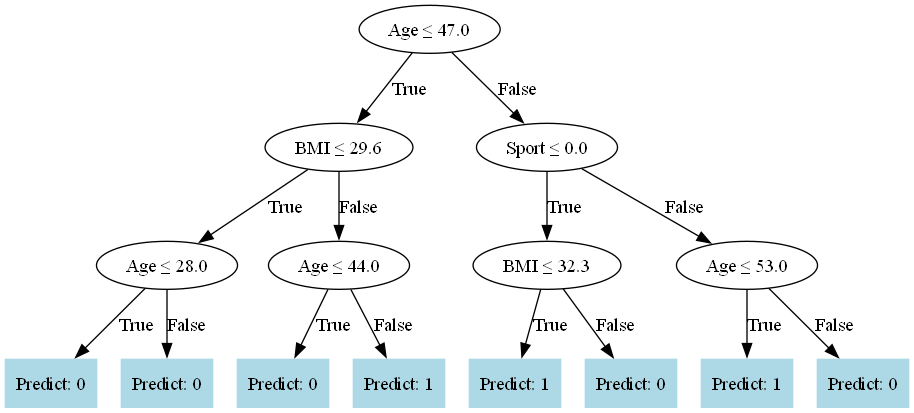

In [11]:
from graphviz import Digraph

def draw_tree_graphviz(node, feature_names, dot=None, counter=[0]):
    """
    Recursively draw a decision tree using graphviz.
    """
    if dot is None:
        dot = Digraph()
    
    node_id = str(counter[0])
    counter[0] += 1

    # Leaf node
    if node.value is not None:
        label = f"Predict: {node.value}"
        dot.node(node_id, label, shape="box", style="filled", color="lightblue")
        return dot, node_id

    # Internal node
    label = f"{feature_names[node.feature]} ≤ {node.threshold}"
    dot.node(node_id, label, shape="ellipse")

    # Left (True) branch
    dot, left_id = draw_tree_graphviz(node.left, feature_names, dot, counter)
    dot.edge(node_id, left_id, label="True")

    # Right (False) branch
    dot, right_id = draw_tree_graphviz(node.right, feature_names, dot, counter)
    dot.edge(node_id, right_id, label="False")

    return dot, node_id

# Example usage:
feature_names = ['Age', 'Sex', 'Smoker', 'BMI', 'Sport']
dot, _ = draw_tree_graphviz(tree, feature_names)

# Save and/or display
# dot.render("Decision_Tree_Visualization", format='png', cleanup=True)
# dot.view()  # Opens the image in default viewer if running locally
from IPython.display import Image, display

# Tampilkan langsung di notebook
display(Image(dot.pipe(format='png')))


### 🧪 9: Train-Test Split and Accuracy Evaluation (Manual)

To evaluate how well our manually-built decision tree generalizes, we split the dataset into **training** and **testing** sets manually.

Then we:
1. Build the tree using only the training data
2. Predict using the testing data
3. Compare predicted vs actual labels to compute accuracy


In [12]:
from random import shuffle

# 1. Split manually without sklearn
shuffle(data)
split_idx = int(0.8 * len(data))
train_data = data[:split_idx]
test_data = data[split_idx:]

# 2. Build tree on train_data
tree = build_tree(train_data)

# 3. Predict on test_data
def evaluate_accuracy(tree, test_data):
    correct = 0
    for row in test_data:
        pred = predict(row, tree)
        if pred == row[-1]:
            correct += 1
    return correct / len(test_data)

accuracy = evaluate_accuracy(tree, test_data)
print(f"Manual Decision Tree Accuracy (on test set): {accuracy:.4f}")


Manual Decision Tree Accuracy (on test set): 0.6250


## 📈 10. Accuracy and Confusion Matrix

In [13]:



from sklearn.metrics import confusion_matrix, accuracy_score

y_true = [row[-1] for row in data]
y_pred = [predict(row, tree) for row in data]

conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.2f}")

Confusion Matrix:
[[85 35]
 [24 56]]
Accuracy: 0.70
